<h1>Module 16 Project Template</h1>

Use the code below to help you analyze the data returned by the MBTA API:

In [224]:
mbtaURL = "https://api-v3.mbta.com/vehicles?filter[route]=1&include=trip"

import urllib.request, json
with urllib.request.urlopen(mbtaURL) as url:
    data = json.loads(url.read().decode())
   
    with open('data.json', 'w') as outfile:
        json.dump(data, outfile)
   
    with open('data.txt', 'w') as outfile:
        json.dump(json.dumps(data, indent=4, sort_keys=True), outfile)
       
    print(json.dumps(data, indent=4, sort_keys=True))


{
    "data": [
        {
            "attributes": {
                "bearing": 201,
                "carriages": [],
                "current_status": "IN_TRANSIT_TO",
                "current_stop_sequence": 16,
                "direction_id": 1,
                "label": "1872",
                "latitude": 42.34071946,
                "longitude": -71.082177339,
                "occupancy_status": "MANY_SEATS_AVAILABLE",
                "revenue": "REVENUE",
                "speed": null,
                "updated_at": "2024-09-17T23:26:27-04:00"
            },
            "id": "y1872",
            "links": {
                "self": "/vehicles/y1872"
            },
            "relationships": {
                "route": {
                    "data": {
                        "id": "1",
                        "type": "route"
                    }
                },
                "stop": {
                    "data": {
                        "id": "84",
                        "ty

Use the code below to read the data from your MySQL database and store it in a pandas dataframe.  

You you need to install pymysql to run the code:

pip install pymysql

In [225]:
import os
import pymysql
import pandas as pd

host = '127.0.0.1'
port = '3306'
user = 'root'
password = 'MyNewPass'
database = 'MBTAdb'

conn = pymysql.connect(
    host=host,
    port=int(3306),
    user="root",
    passwd=password,
    db=database,
    charset='utf8mb4')

df = pd.read_sql_query("SELECT * FROM mbta_buses",
    conn)

df.tail(10)

C:\Users\markg\AppData\Local\Temp\ipykernel_5080\2324256652.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("SELECT * FROM mbta_buses",


,record_num,id,latitude,longitude,direction,current_status,label,occupancy_status,speed,updated_at,current_stop_sequence
39262,39263,y1839,42.348590,-71.088410,1,IN_TRANSIT_TO,1839,FULL,None,2024-09-17T19:33:40-04:00,12
39263,39264,y1828,42.373130,-71.117730,1,STOPPED_AT,1828,MANY_SEATS_AVAILABLE,None,2024-09-17T19:33:08-04:00,1
39264,39265,y1800,42.329840,-71.083510,0,STOPPED_AT,1800,FEW_SEATS_AVAILABLE,None,2024-09-17T19:33:40-04:00,1
39265,39266,y3210,42.337480,-71.078230,1,STOPPED_AT,3210,FEW_SEATS_AVAILABLE,None,2024-09-17T19:33:57-04:00,16
39266,39267,y1870,42.342617,-71.084698,0,STOPPED_AT,1870,MANY_SEATS_AVAILABLE,None,2024-09-17T19:34:03-04:00,11
39267,39268,y1865,42.361583,-71.097453,0,IN_TRANSIT_TO,1865,FULL,None,2024-09-17T19:34:03-04:00,17
39268,39269,y1846,42.358441,-71.093407,1,STOPPED_AT,1846,MANY_SEATS_AVAILABLE,None,2024-09-17T19:34:04-04:00,10
39269,39270,y1839,42.348590,-71.088410,1,IN_TRANSIT_TO,1839,FULL,None,2024-09-17T19:33:40-04:00,12
39270,39271,y1828,42.373130,-71.117730,1,STOPPED_AT,1828,MANY_SEATS_AVAILABLE,None,2024-09-17T19:33:08-04:00,1
39271,39272,y1800,42.329840,-71.083510,0,STOPPED_AT,1800,FEW_SEATS_AVAILABLE,None,2024-09-17T19:33:40-04:00,1



The code below saves the data as a csv file to the local directory as a backup.

In [226]:

df.to_csv('mbta.csv')

<h1>What is the average time it takes for a bus to complete the route</h1>

In [227]:
from datetime import datetime, timedelta
from statistics import mean

def stripMicroseconds(time):
    return time - timedelta(microseconds=time.microseconds)

data = pd.read_csv('mbta.csv')
average_times = []
chart_data = []
# all data is from 9/17/2024, remove the date from updated_at along with the "-4:00" at the end
data['updated_at'] = data['updated_at'].str.split('T').str[1]
data['updated_at'] = data['updated_at'].str.split('-').str[0]

# get all bus IDs
buses = data['id'].unique()

#filter for buses stopped at a station and on direction 0 (Nubian to Harvard)
stopped = data[data['current_status'] == 'STOPPED_AT']
northbound = stopped[stopped['direction'] == 0]

# for each bus, create a list of how long each trip from Nubian to Harvard took
for bus_id in buses:
    bus = northbound[northbound['id'] == bus_id]
    
    # check this bus later, seems it didn't finish the loop
    lap = []
    current_stop = 1
    previous_stop = 23
    
    # current_stop == 1 represents every time a bus arrives at the first stop on the northbound
    # leg of the route. store the lap time each time the stop changes from 23 to 1 when 
    # direction is 0 (filtered above)
    for index,row in bus.iterrows():
        current_stop = row['current_stop_sequence']
        if current_stop == 1 and previous_stop == 23:
            lap.append(row['updated_at'])
        previous_stop = current_stop
    format = '%H:%M:%S'
    # Convert the time strings to datetime objects
    lap = [datetime.strptime(time_str, format) for time_str in lap]
    
    # Calculate differences between consecutive times
    lap_times = []
    for i in range(1, len(lap)):
        time_difference = lap[i] - lap[i - 1]
        lap_times.append(time_difference)
    if len(lap_times) < 2:
        continue
    chart_data.append([lap,lap_times])
    
    # Calculate the average time difference
    total_difference = sum(lap_times, timedelta())
    average_difference = stripMicroseconds(total_difference / len(lap_times))
    
    print('Average time for bus',row['label'],': ',average_difference)
    average_times.append(average_difference)

# calculate and print final results
total = sum(average_times, timedelta())
total_average = stripMicroseconds(total/len(average_times))

print('Average time for MBTA Route 1 bus to make a roundtrip from Nubian Square to Harvard Square: ',total_average)

Average time for bus 3263 :  1:28:27
Average time for bus 3250 :  2:12:18
Average time for bus 1740 :  1:41:48
Average time for bus 1828 :  1:46:28
Average time for bus 3226 :  1:48:22
Average time for bus 1865 :  1:41:49
Average time for bus 3278 :  1:51:32
Average time for bus 1764 :  2:07:27
Average time for bus 1870 :  2:05:03
Average time for bus 1800 :  1:56:57
Average time for MBTA Route 1 bus to make a roundtrip from Nubian Square to Harvard Square:  1:52:01


<h1>Provide a Visualization based on the data</h1>

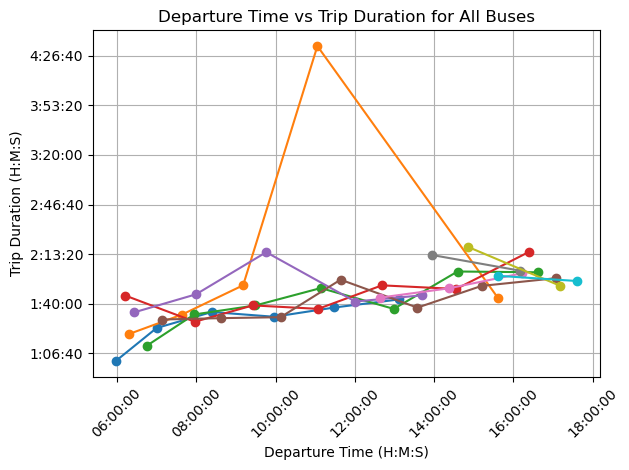

In [228]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#x-axis: departure time
#y-axis: length of trip

# Create a single plot for all datasets
fig, ax = plt.subplots()

# Loop through each dataset in chart_data
for index, data in enumerate(chart_data):
    times = data[0]  # Times of day
    durations = data[1]  # Durations

    # Convert durations to total seconds for plotting
    lengths_in_seconds = [td.total_seconds() for td in durations]

    # Ensure times and lengths_in_seconds are the same length
    min_length = min(len(times), len(lengths_in_seconds))
    times = times[:min_length]
    lengths_in_seconds = lengths_in_seconds[:min_length]

    # Plotting the data for the current dataset
    ax.plot(times, lengths_in_seconds, marker='o', label=f'Dataset {index + 1}')

# Formatting the x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.xticks(rotation=45)

# Formatting the y-axis to show H:M:S
def seconds_to_hms(x):
    return str(datetime.timedelta(seconds=x))

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: seconds_to_hms(x)))

# Adding labels and title
ax.set_xlabel('Departure Time (H:M:S)')
ax.set_ylabel('Trip Duration (H:M:S)')
ax.set_title('Departure Time vs Trip Duration for All Buses')

# Show grid
ax.grid()

# Show the plot
plt.tight_layout()
plt.show()

<h1>Give an estimate of the speed of the bus from current_stop_sequence = 1 to the last  current_stop_sequence. </h1> 

Note: You can use the haversine Python library to calculate the distance between two points, given two longitude and latitude coordinates.

In [229]:
import pandas as pd
from haversine import haversine, Unit

# read the data and filter for the northbound 1828 bus when it's stopped
data = pd.read_csv('mbta.csv')
stopped = data[data['current_status'] == 'STOPPED_AT']
northbound = stopped[stopped['direction'] == 0]
bus = northbound[northbound['label'] == 1828]

# get data from the last row with 1 as the current_stop_sequence
for index,stop in bus.iterrows():
    if stop['current_stop_sequence'] == 2:
        origin = [last['latitude'], last['longitude']]
        origin_time = last['updated_at']
        break
    else:
        last = stop

# get data from the first row with 23 as the current_stop_sequence
for index,dest in bus.iterrows():
    if dest['current_stop_sequence'] == 23:
        break
dest_time = dest['updated_at']
dest = [dest['latitude'], dest['longitude']]

# Calculate the distance
distance = haversine(origin, dest, unit=Unit.MILES)

origin_time = pd.to_datetime(origin_time)
dest_time = pd.to_datetime(dest_time)

# Calculate the time difference
time = dest_time - origin_time
time_in_hours  = time.total_seconds() / 3600 

speed = distance / time_in_hours
print(f"Speed: {speed:.2f} miles per hour")


Speed: 6.50 miles per hour
